# Prototype: Compute cell volumes using lookup table in HEC-RAS HDF5 file

In [ ]:
import pandas as pd
import numpy as np
import numba
import h5py

## Read data from HDF5

### NOTE:
This is failing to read with recent versions of h5py. I tested this on MacOs and Windows. Conda is using hdf=1.10. I think the RAS team is using HDF5 V1.12.0.

In [ ]:
# with h5py.File('../tests/input_files/Muncie.p04.hdf', 'r') as infile:
    # cells_volume_info = infile['Geometry/2D_Flow_Areas/2D_Interior_Area/Cells_Volume_Elevation_Info'][()]
    # cells_elev_vol = infile['Geometry/2D_Flow_Areas/2D_Interior_Area/Cells_Volume_Elevation_Values'][()]
    # cells_surface_area = infile['Geometry/2D_Flow_Areas/2D_Interior_Area/Cells_Surface_Area'][()]
    # water_surface_elev = infile['Results/Unsteady/Output/Output_Blocks/Base_Output/Unsteady_Time_Series/2D_Flow_Areas/2D_Interior_Area/Water_Surface'][()]
    # Test:
    # print(infile[f'Geometry/2D Flow Areas/Perimeter 1/Faces NormalUnitVector and Length'][()][:,2]) 

## Read the RAS data

Note: I exported the data we need from the HDF5 file to CSV files using Panoply

In [6]:
cells_volume_info_df = pd.read_csv('Cells_Volume_Elevation_Info.csv', names = ['Index', 'Count'])
cells_elev_vol_df = pd.read_csv('Cells_Volume_Elevation_Values.csv', names=['Elevation', 'Volume'])
cells_surface_area_df = pd.read_csv('Cells_Surface_Area.csv', names = range(5765))
water_surface_elev_df = pd.read_csv('Water_Surface.csv', names = range(5765))

In [7]:
index_arr = cells_volume_info_df.Index.to_numpy()
count_arr = cells_volume_info_df.Count.to_numpy()
elev_arr = cells_elev_vol_df.Elevation.to_numpy()
vol_arr = cells_elev_vol_df.Volume.to_numpy()
water_surface_elev_arr = water_surface_elev_df.to_numpy()
cells_surface_area_arr = cells_surface_area_df.to_numpy()[0]

## Compute cell volume

In [8]:
@numba.njit
def compute_volume(water_surface_elev_arr: np.array, cells_surface_area_arr: np.array, index_arr: np.array, count_arr: np.array, elev_arr: np.array, vol_arr: np.array, time: int, cell: int, VERBOSE=False) -> float:
    water_surface_elev = water_surface_elev_arr[time, cell]
    surface_area = cells_surface_area_arr[cell]
    index = index_arr[cell] # Start index in the volume-elevation table for this cell
    count = count_arr[cell] # Number of points in the table for this cell

    # A number of cells have an index that is just past the end of the array. Return a volume of 0.0 for these cells. The count for these cells should also be zero, but
    # we are checking for either condition.
    if index >= len(elev_arr) or count == 0:
        return 0.0

    elev = elev_arr[index:index + count] # Get the elevation table for this cell
    vol = vol_arr[index:index + count] # Get the volume table for this cell

    if water_surface_elev > elev[-1]:
        # Compute the net volume: the max volume in the lookup table plus the volume of the water above the max elevation in the lookup table
        net_vol = vol[-1] + (water_surface_elev - elev[-1]) * surface_area
    elif water_surface_elev == elev[-1]:
        net_vol = vol[-1]
    elif water_surface_elev == elev[0]:
        net_vol = vol[0]
    else:
        # Interpolate
        net_vol = 0.0 # Default
        npts = len(elev)
        for i in range(npts-1, -1, -1):
            if elev[i] > water_surface_elev:
                x = water_surface_elev
                m = (vol[i] - vol[i-1])/(elev[i] - elev[i-1])
                x1 = elev[i]
                y1 = vol[i]
                # y = m * (x - x1) + y1
                net_vol = m * (x - x1) + y1

    if VERBOSE:
        print('water_surface_elev:', water_surface_elev)
        print('surface_area:', surface_area)
        print('index:', index)
        print('count:', count)
        print('cell:', cell)
        print('elev:', elev)
        print('len(elev_arr):', len(elev_arr))
        print('vol:', vol)
        print('net_vol:', net_vol)
    return net_vol

In [9]:
time = 288
cell = 5764
compute_volume(water_surface_elev_arr, cells_surface_area_arr, index_arr, count_arr, elev_arr, vol_arr, time, cell, VERBOSE=True)

0.0

In [10]:
@numba.njit
def compute(water_surface_elev_arr: np.array, cells_surface_area_arr: np.array, index_arr: np.array, count_arr: np.array, elev_arr: np.array, vol_arr: np.array, ntimes: int, ncells: int):
    cell_volumes = np.zeros((ntimes, ncells))

    for cell in range(ncells):
        for time in range(ntimes):
            cell_volumes[time, cell] = compute_volume(water_surface_elev_arr, cells_surface_area_arr, index_arr, count_arr, elev_arr, vol_arr, time, cell)

    return cell_volumes

## Example

In [11]:
ncells = 5765
ntimes = 289

cell_volumes = compute(water_surface_elev_arr, cells_surface_area_arr, index_arr, count_arr, elev_arr, vol_arr, ntimes, ncells)
cell_volumes_df = pd.DataFrame(cell_volumes, columns = range(ncells))
cell_volumes_df

,0,1,2,3,4,5,6,7,8,9,...,5755,5756,5757,5758,5759,5760,5761,5762,5763,5764
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,11792.666164,10590.386708,11706.806031,11265.542608,10994.971934,15224.410916,13296.915121,15513.241294,17617.318488,19062.152359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
285,11789.296058,10587.454330,11703.642113,11262.311979,10991.288480,15220.688862,13293.504522,15508.996372,17612.455298,19057.000196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,11785.826832,10584.521952,11700.478195,11259.081351,10987.605026,15216.828954,13289.967605,15504.781555,17607.626599,19051.884572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
287,11782.357605,10581.589573,11697.314277,11255.850722,10983.921573,15212.969046,13286.430688,15500.566738,17602.797900,19046.768949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


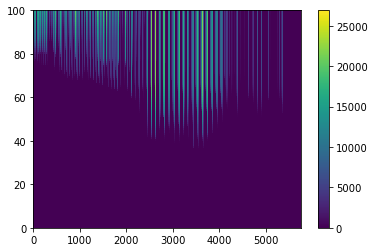

In [12]:
import matplotlib.pyplot as plt
plt.pcolor(cell_volumes[range(100)])
cb = plt.colorbar()

In [ ]:
cell_volumes_df[range(100)].plot()